### 1. Import Libraries and Set Environment Variables

In [1]:
# import libraries
import os
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay,
)

import constants as const

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# set environment variable to avoid QT related error
os.environ["QT_QPA_PLATFORM"] = "offscreen"

### 2. Import Data

In [3]:
def import_data(pth: str) -> pd.DataFrame or None:
    """
    returns dataframe for the csv found at pth

    Parameters
    ----------
    pth : str
        a path to csv file

    Returns
    -------
    pd.DataFrame or None
        pandas dataframe if valid path else None
    """
    try:
        df = pd.read_csv(pth, index_col=0)
        print("File imported successfully")
        return df
    except FileNotFoundError:
        print("File not found, please check the path and try again")
        return None

In [4]:
# import the dataframe
df = import_data(r"./data/bank_data.csv")
df.head()

File imported successfully


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### 3. Exploratory Data Analysis

In [5]:
def add_churn_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    add churn column to dataframe based on Attrition_Flag column

    Parameters
    ----------
    df : pd.DataFrame
        dataframe to add churn column to

    Returns
    -------
    pd.DataFrame
        dataframe with churn column added
    """
    try:
        df["Churn"] = df["Attrition_Flag"].apply(
            lambda val: 0 if val == "Existing Customer" else 1
        )
        print("Churn column added successfully")
        return df
    except KeyError:
        print("Dataframe does not have Attrition_Flag column")
        return df

In [6]:
# add churn column to the dataframe
df = add_churn_column(df)
df.head()

Churn column added successfully


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


In [7]:
# print the shape of the dataframe
print(f"The shape of the dataframe is: {df.shape}")
# print sum of null values over all columns in dataframe
print(f"The sum of null values in the dataframe is: {df.isnull().sum().sum()}")

The shape of the dataframe is: (10127, 22)
The sum of null values in the dataframe is: 0


In [8]:
# print the descriptive statistics of the dataframe
print(f"The descriptive statistics of the dataframe is:")
df.describe()

The descriptive statistics of the dataframe is:


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.160660
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.367235
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,1.000000


In [9]:
def perform_eda(df: pd.DataFrame) -> None:
    """
    perform exploratory data analysis on df and save figures to images folder

    Parameters
    ----------
    df : pd.DataFrame
        dataframe to perform eda on

    Returns
    -------
    None
    """
    pth = "./images/eda"
    # check if image directory already exists
    if os.path.isdir(pth):
        print(f"{pth} directory already exists")
    else:
        # create directory
        os.makedirs(pth)
        print(f"{pth} directory created")

    # create plots
    # plot distribution of individual variables
    for col in df.columns:
        _, ax = plt.subplots()
        ax = sns.histplot(df[col])
        ax.figure.tight_layout()
        plt.savefig(f"{pth}/{col}_dist.png")
        plt.close()

    # plot distribution of individual variables and add a smooth curve obtained
    # using a kernel density estimate
    for col in df.columns:
        _, ax = plt.subplots()
        ax = sns.histplot(df[col], kde=True)
        ax.figure.tight_layout()
        plt.savefig(f"{pth}/{col}_dist_kde.png")
        plt.close()

    # plot correlation heatmap
    # ensure that only quantitative variables are passed to the heatmap
    try:
        _, ax = plt.subplots()
        ax = sns.heatmap(
            df[const.QUANT_COLUMNS].corr(), annot=False, cmap="coolwarm"
        )
        ax.figure.tight_layout()
        plt.savefig(f"{pth}/corr_heatmap.png")
        plt.close()
    except ValueError:
        print(
            "Correlation heatmap could not be generated due to incorrect column types"
        )
    except KeyError:
        print(
            "Correlation heatmap could not be generated due to incorrect column names"
        )

    # plot count of target variable
    try:
        _, ax = plt.subplots()
        ax = sns.countplot(x="Churn", data=df)
        ax.figure.tight_layout()
        plt.savefig(f"{pth}/target_count.png")
        plt.close()
    except ValueError:
        print("Target variable churn could not be found")
    except KeyError:
        print("Target variable churn could not be found")

    # plot distribution of target variable
    try:
        _, ax = plt.subplots()
        ax = sns.histplot(df["Churn"])
        ax.figure.tight_layout()
        plt.savefig(f"{pth}/target_dist.png")
        plt.close()
    except ValueError:
        print("Target variable churn could not be found")
    except KeyError:
        print("Target variable churn could not be found")

    # plot count of target variable grouped by categorical variables
    try:
        for col in df.columns:
            if df[col].dtype == "object":
                _, ax = plt.subplots()
                ax = sns.countplot(x=col, hue="Churn", data=df)
                ax.figure.tight_layout()
                plt.savefig(f"{pth}/{col}_count.png")
                plt.close()
    except ValueError:
        print("Target variable churn could not be found")
    except KeyError:
        print("Target variable churn could not be found")

    # plot distribution of target variable grouped by categorical variables
    try:
        for col in df.columns:
            if df[col].dtype == "object":
                _, ax = plt.subplots()
                ax = sns.histplot(x=col, hue="Churn", data=df)
                ax.figure.tight_layout()
                plt.savefig(f"{pth}/{col}_dist.png")
                plt.close()
    except ValueError:
        print("Target variable churn could not be found")
    except KeyError:
        print("Target variable churn could not be found")

    return None

In [10]:
# perform the exploratory data analysis
# and save the figures to the images folder
perform_eda(df)

./images/eda directory already exists


### 4. Feature Engineering

In [11]:
def encoder_helper(df: pd.DataFrame, response: str = "Churn") -> pd.DataFrame:
    """
    helper function to turn each categorical column into a new column with
    propotion of churn for each category

    Parameters
    ----------
    df : pandas dataframe
    response : str, optional
        string of response name, by default "Churn"

    Returns
    -------
    pd.DataFrame
        dataframe with new columns for each categorical column
    """
    # copy the dataframe
    df = df.copy()
    # iterate over each categorical column
    for col in const.CAT_COLUMNS:
        try:
            # check if the column is in the dataframe
            if col not in df.columns:
                print(f"Column {col} not found")
                continue
            # create a new column name for each category
            new_col = col + "_" + response
            # create a new column with the proportion of churn for each category
            col_groups = df[[col, response]].groupby(col).mean()[response]
            df[new_col] = [col_groups.loc[val] for val in df[col]]
        except KeyError:
            print("Response column not found")
    # drop the original categorical columns
    df.drop(const.CAT_COLUMNS, axis=1, inplace=True)
    # drop the response column
    try:
        df.drop(response, axis=1, inplace=True)
    except KeyError:
        print("Response column not found")
    return df

In [12]:
def perform_feature_engineering(
    df: pd.DataFrame, response: str = "Churn"
) -> list or None:
    """
    perform feature engineering on df and return X_train, X_test, y_train, y_test

    Parameters
    ----------
    df : pandas dataframe
    response : str, optional
        string of response name, by default "Churn"

    Returns
    -------
    list or None
        X_train: X training data
        X_test: X testing data
        y_train: y training data
        y_test: y testing data
    """
    # turn each categorical column into a new column with propotion of churn for
    # each category; only keep the columns we want to use for modeling
    try:
        X = encoder_helper(df, response)[const.KEEP_COLS]
    except KeyError:
        print(
            "The columns you are trying to keep do not exist in the dataframe"
        )
        return None
    # get the target variable
    try:
        y = df[response]
    except KeyError:
        print("The target variable does not exist in the dataframe")
        return None
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=const.TEST_SIZE, random_state=const.RAND_STATE
    )
    return [X_train, X_test, y_train, y_test]

In [13]:
# perform feature engineering
X_train, X_test, y_train, y_test = perform_feature_engineering(df, "Churn")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7088, 19), (3039, 19), (7088,), (3039,))

### 5. Model Training

In [14]:
def train_models(
    X_train: pd.DataFrame or np.array, y_train: pd.Series or np.array
) -> list:
    """
    train and store models.

    Parameters
    ----------
    X_train : array-like
        X training data
    y_train : array-like
        y training data

    Returns
    -------
    list
        list of models
    """
    # grid search
    rfc = RandomForestClassifier(random_state=const.RAND_STATE)
    # Use a different solver if the default 'lbfgs' fails to converge
    # Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    lrc = LogisticRegression(
        solver=const.LR_SOLVER, max_iter=const.LR_MAX_ITER
    )

    # fit models
    cv_rfc = GridSearchCV(
        estimator=rfc, param_grid=const.GRID_PARAM, cv=const.GRID_CV
    )
    cv_rfc.fit(X_train, y_train)
    lrc.fit(X_train, y_train)

    # save models (best estimator for random forest)
    pth = "./models"
    # check if models directory already exists
    if os.path.isdir(pth):
        print(f"{pth} directory already exists")
    else:
        # create directory
        os.makedirs(pth)
        print(f"{pth} directory created")
    joblib.dump(cv_rfc.best_estimator_, f"{pth}/rfc_model.pkl")
    joblib.dump(lrc, f"{pth}/lrc_model.pkl")

    # return models
    return [cv_rfc.best_estimator_, lrc]

In [15]:
# train models
rfc, lrc = train_models(X_train, y_train)

./models directory already exists


In [17]:
# load models
rfc = joblib.load("./models/rfc_model.pkl")
lrc = joblib.load("./models/lrc_model.pkl")

### 6. Model Evaluation

In [28]:
def test_model(
    X_train: pd.DataFrame or np.array,
    X_test: pd.DataFrame or np.array,
    y_train: pd.Series or np.array,
    y_test: pd.Series or np.array,
    model: BaseEstimator,
) -> None:
    """
    test and store model results: images + scores

    Parameters
    ----------
    X_train : array-like
        X training data
    X_test : array-like
        X testing data
    y_train : array-like
        y training data
    y_test : array-like
        y testing data
    model : BaseEstimator
        model object

    Returns
    -------
    None
    """
    # predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    pth = "./images/results"
    # check if image directory already exists
    if os.path.isdir(pth):
        print(f"{pth} directory already exists")
    else:
        # create directory
        os.makedirs(pth)
        print(f"{pth} directory created")

    # roc curve image
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(
        fpr=fpr,
        tpr=tpr,
        roc_auc=roc_auc,
        estimator_name=model.__class__.__name__,
    )
    display.plot()
    plt.savefig(f"{pth}/{model.__class__.__name__}_roc_curve.png")
    plt.close()

    # classification report image
    plt.rc("figure", figsize=(8, 5))
    plt.text(
        0.01,
        1.25,
        str(f"{model.__class__.__name__} Train"),
        {"fontsize": 10},
        fontproperties="monospace",
    )
    plt.text(
        0.01,
        0.05,
        str(classification_report(y_test, y_pred_test)),
        {"fontsize": 10},
        fontproperties="monospace",
    )
    plt.text(
        0.01,
        0.6,
        str(f"{model.__class__.__name__} Test"),
        {"fontsize": 10},
        fontproperties="monospace",
    )
    plt.text(
        0.01,
        0.7,
        str(classification_report(y_train, y_pred_train)),
        {"fontsize": 10},
        fontproperties="monospace",
    )
    plt.axis("off")
    plt.savefig(f"{pth}/{model.__class__.__name__}_classification_report.png")
    plt.close()

    return None

In [29]:
# test models both with X_train and X_test
test_model(X_train, X_test, y_train, y_test, rfc)
test_model(X_train, X_test, y_train, y_test, lrc)

./images/results directory already exists
./images/results directory already exists


### 7. Feature Importances

In [36]:
def feature_importance_plot(
    model: BaseEstimator, X_data: pd.DataFrame or np.array
) -> None:
    """
    creates and stores the feature importances in pth

    Parameters
    ----------
    model : BaseEstimator
        classifier model
    X_data : array-like
        input data

    Returns
    -------
    None
    """
    pth = "./images/results"
    # check if image directory already exists
    if os.path.isdir(pth):
        print(f"{pth} directory already exists")
    else:
        # create directory
        os.makedirs(pth)
        print(f"{pth} directory created")

    # calculate feature importance using shap
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_data)
    shap.summary_plot(shap_values, X_data, plot_type="bar")
    plt.savefig(f"{pth}/{model.__class__.__name__}_feature_importance.png")
    plt.close()

    return None

./images/results directory already exists


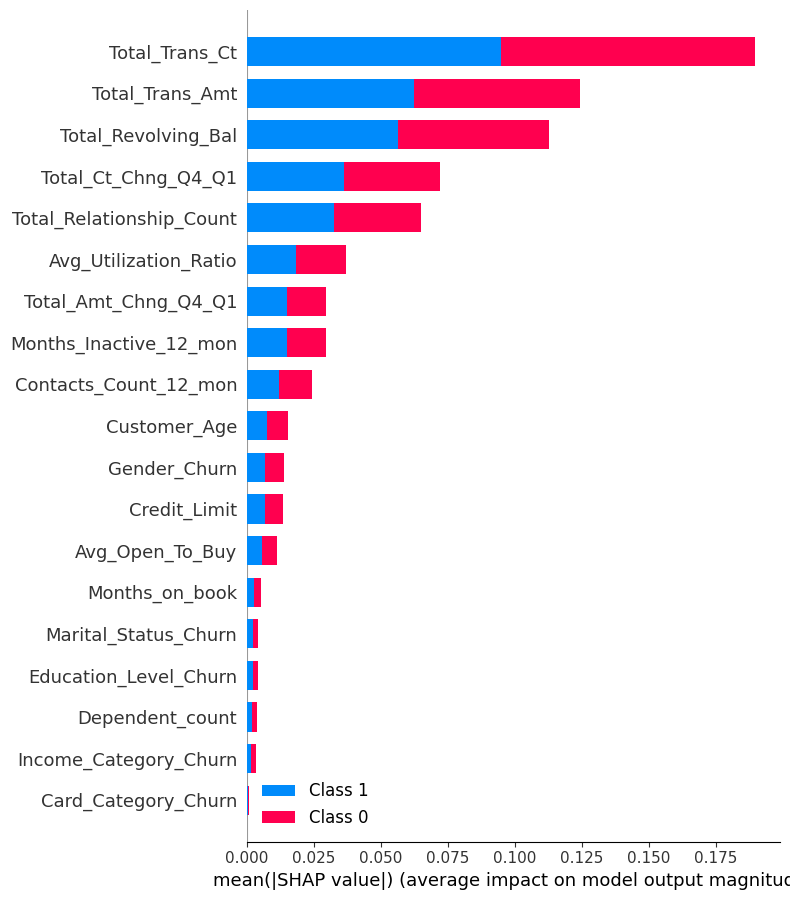

In [37]:
# get feature importance plots
feature_importance_plot(rfc, X_test)